In [16]:
from __future__ import division
import pandas as pd
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost.sklearn import XGBClassifier

# Roger Federer Win Prediction

![title](fed.jpg)

## Introduction
Roger Federer is arguably one of the greatest tennis players of all time. Over his career, he has accumulated more than 1000 wins. 
This year, Federer is returning to professional tennis after suffering a back injury last year. 
Despite winning the first grand slam of the year, the Australian Open, people still question if he will be able to continue to make a major impact.
My goal with this project is to create a classifier to predict whether or not Roger Federer will win a given match as the match progresses. 
To do so, I will focus on percentages measuring levels of efficiency in various areas of the game.

## Gathering the Data (Already Executed)
The ATP (Association of Tennis Professionals) reports most of the major statistics for professional tennis matches. I wanted to get as many statistics as possible for all of Roger Federer's matches. Here are the steps I followed:
1. I downloaded federer.htm by manually saving the html from http://www.atpworldtour.com/players/roger-federer/f324/player-activity?year=all
    - This website contains the match scores for all of Roger Federer's professional matches. When you click on the final score of the match, you are taking to a new page that contains all of the match-specific statistics.
- I wrote a script, `tennis.py`, that scrapes all 1200+ matches and the associated stats. The final output of this script is the group of files, `match_overview.pkl`, `federer.pkl`, and `opponent.pkl`. An explanation for my scraping methods are addressed in the `tennis.py` script.
- This notebook begins with the cleaning of these pickled files.
- __NOTE__: for cleanliness, the contents of `tennis.py` are not contained in this notebook. The script, along with full annotations, is included with this notebook.

## Cleaning the Data

In [3]:
match = pd.read_pickle("match_overview.pkl")
roger = pd.read_pickle("roger.pkl")
opp = pd.read_pickle("opponent.pkl")

### A quick glimpse at the data as is

In [4]:
match.head()

,MatchID,TourneyDate,Opp,Rank,Round,Result,Score
0,0,2017.01.16 - 2017.01.29,Rafael Nadal,9,Finals,W,64 36 61 36 63
1,2,2017.01.16 - 2017.01.29,Stan Wawrinka,4,Semi-Finals,W,75 63 16 46 63
2,5,2017.01.16 - 2017.01.29,Mischa Zverev,50,Quarter-Finals,W,61 75 62
3,9,2017.01.16 - 2017.01.29,Kei Nishikori,5,Round of 16,W,674 64 61 46 63
4,14,2017.01.16 - 2017.01.29,Tomas Berdych,10,Round of 32,W,62 64 64


In [5]:
roger.head()

,MatchID,Aces,AcesPercentage,BreakPointsConvertedDividend,BreakPointsConvertedDivisor,BreakPointsConvertedPercentage,BreakPointsSavedDividend,BreakPointsSavedDivisor,BreakPointsSavedPercentage,DoubleFaults,...,Time,TotalPointsWonDividend,TotalPointsWonDivisor,TotalPointsWonPercentage,TotalReturnPointsWonDividend,TotalReturnPointsWonDivisor,TotalReturnPointsWonPercentage,TotalServicePointsWonDividend,TotalServicePointsWonDivisor,TotalServicePointsWonPercentage
0,0,20,83.3333,6,20,30,13,17,76,3,...,00:00:00,150,289,52,59,151,39,91,138,66
1,2,11,52.381,4,9,44,8,12,67,3,...,00:00:00,142,278,51,47,135,35,95,143,66
2,5,9,64.2857,6,15,40,1,2,50,1,...,00:00:00,100,176,57,46,97,47,54,79,68
3,9,24,85.7143,7,18,39,6,9,67,6,...,00:00:00,169,310,55,67,164,41,102,146,70
4,14,8,40,4,5,80,0,0,0,2,...,00:00:00,85,151,56,29,81,36,56,70,80


In [6]:
opp.head()

,MatchID,Aces,AcesPercentage,BreakPointsConvertedDividend,BreakPointsConvertedDivisor,BreakPointsConvertedPercentage,BreakPointsSavedDividend,BreakPointsSavedDivisor,BreakPointsSavedPercentage,DoubleFaults,...,Time,TotalPointsWonDividend,TotalPointsWonDivisor,TotalPointsWonPercentage,TotalReturnPointsWonDividend,TotalReturnPointsWonDivisor,TotalReturnPointsWonPercentage,TotalServicePointsWonDividend,TotalServicePointsWonDivisor,TotalServicePointsWonPercentage
0,0,4,16.6667,4,17,24,14,20,70,3,...,00:00:00,139,289,48,47,138,34,92,151,61
1,2,10,47.619,4,12,33,5,9,56,2,...,00:00:00,136,278,49,48,143,34,88,135,65
2,5,5,35.7143,1,2,50,9,15,60,0,...,00:00:00,76,176,43,25,79,32,51,97,53
3,9,4,14.2857,3,9,33,11,18,61,5,...,00:00:00,141,310,45,44,146,30,97,164,59
4,14,12,60,0,0,0,1,5,20,3,...,00:00:00,66,151,44,14,70,20,52,81,64


The features I have chosen to use are:
- __Aces__ : A legal serve not touched by the receiver
- __DoubleFaults__ : Missing two serves in a row
- __BreakPointsConvertedPercentage__ : The percentage of break points won while receiving.
- __BreakPointsSavedPercentage__ : The percentage of break points won while serving
- __FirstServePercentage__ : The percentage of first serves that were put into play
- __FirstServePointsWonPercentage__ : The percentage of points won when the first serve goes in while serving.
- __FirstServeReturnPointsPercentage__ : The percentage of points won when the opponent gets the first serve in.
- __SecondServePointsWonPercentage__ : The percentage of points won when the second serve goes in while serving.
- __SecondServePointsPercentage__ : The percentage of points won when the opponent gets the second serve in.

## Normalizing the data
Before using these columns, a little bit of processing needs to be done. 
The length of a tennis match can vary widely. 
Therefore, we must normalize some of these columns with respect to the length of the match.

- __AcesPct__ = Aces/TotalServicePoints
    - The percentage of points that were won on an ace.
- __DoubleFaultsPct__ = DoubleFaults/TotalServicePoints
    - The percentage of points that were lost on a double fault.
- __TotBrkPtsForcedPct__ = BreakPointsConvertedDivisor/TotalReturnPoints
    - The percentage of points when returning serve that were break points.
- __TotBrkPtsFacedPct__ = BreakPointsSavedDivsor/TotalServePoints
    - The percentage of points when serving that were break points.

In [7]:
for df in [roger, opp]:
    df["AcesPct"] = df.Aces/df.TotalServicePointsWonDivisor*100
    df["DoubleFaultsPct"] = df.DoubleFaults/df.TotalServicePointsWonDivisor*100
    df["TotBrkPtsForcedPct"] = df.BreakPointsConvertedDivisor/df.TotalReturnPointsWonDivisor*100
    df["TotBrkPtsFacedPct"] = df.BreakPointsSavedDivisor/df.TotalServicePointsWonDivisor*100

Now I trim my data down to the columns mentioned above. These columns exist in the `roger` table and in the `opp` table.

In [8]:
col = ['AcesPct', 'DoubleFaultsPct', 'BreakPointsConvertedPercentage',
       'BreakPointsSavedPercentage', 'TotBrkPtsForcedPct', 'TotBrkPtsFacedPct',
       'FirstServePercentage', 'FirstServePointsWonPercentage', 
       'FirstServeReturnPointsPercentage', 'SecondServePointsPercentage', 
       'SecondServePointsWonPercentage']

roger_trimmed = roger[col]
opp_trimmed = opp[col]

To be able to distinguish between Roger's stats and his opponent's
stats, I will prepend `"opp_"` to all the column names.

In [9]:
opp_trimmed.columns = ['opp_'+c for c in col]

Now I will combine all of Roger's stats and all his opponent's stats into one table.

In [10]:
df = pd.concat([roger_trimmed, opp_trimmed], axis=1)
df.head()

,AcesPct,DoubleFaultsPct,BreakPointsConvertedPercentage,BreakPointsSavedPercentage,TotBrkPtsForcedPct,TotBrkPtsFacedPct,FirstServePercentage,FirstServePointsWonPercentage,FirstServeReturnPointsPercentage,SecondServePointsPercentage,...,opp_DoubleFaultsPct,opp_BreakPointsConvertedPercentage,opp_BreakPointsSavedPercentage,opp_TotBrkPtsForcedPct,opp_TotBrkPtsFacedPct,opp_FirstServePercentage,opp_FirstServePointsWonPercentage,opp_FirstServeReturnPointsPercentage,opp_SecondServePointsPercentage,opp_SecondServePointsWonPercentage
0,14.492754,2.173913,30,76,13.245033,12.318841,62,76,37,44,...,1.986755,24,70,12.318841,13.245033,73,63,24,51,56
1,7.692308,2.097902,44,67,6.666667,8.391608,60,72,37,30,...,1.481481,33,56,8.391608,6.666667,66,63,28,42,70
2,11.392405,1.265823,40,50,15.463918,2.531646,70,69,47,48,...,0.000000,50,60,2.531646,15.463918,74,53,31,33,52
3,16.438356,4.109589,39,67,10.975610,6.164384,67,81,32,58,...,3.048780,33,61,6.164384,10.975610,65,68,19,52,42
4,11.428571,2.857143,80,0,6.172840,0.000000,59,95,17,69,...,3.703704,0,20,0.000000,6.172840,64,83,5,41,31


I now include the match results (found in the `match_overview` table) as the target of the classification.

In [11]:
df['Result'] = match.Result
df.Result.replace('W', 1, inplace=True)
df.Result.replace('L', 0, inplace=True)
df.Result = df.Result.astype(int)

data = df.iloc[:,:-1]
targets = df.iloc[:,-1]

## Visualization
The following plots help to visualize the difference in Roger's stats between when he wins vs when he loses. The histograms below have been normalized so that all the columns of each color add up to 1.

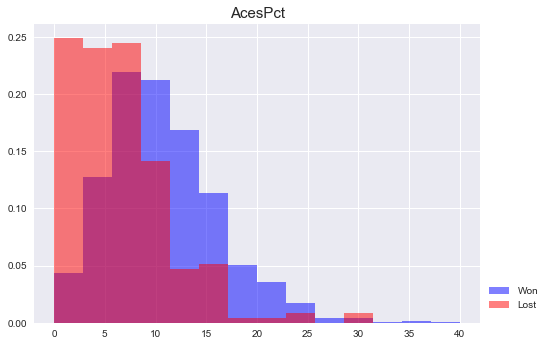

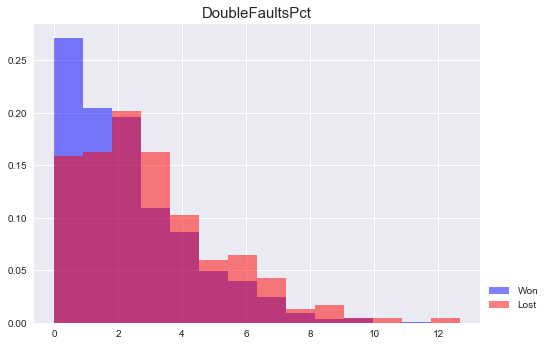

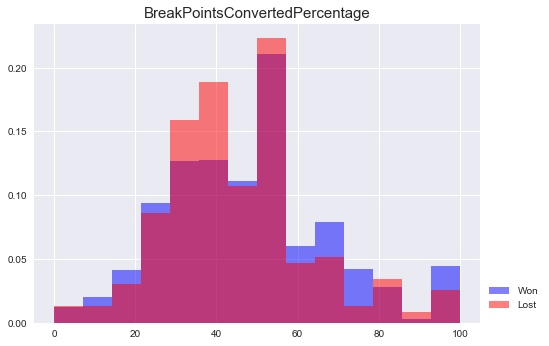

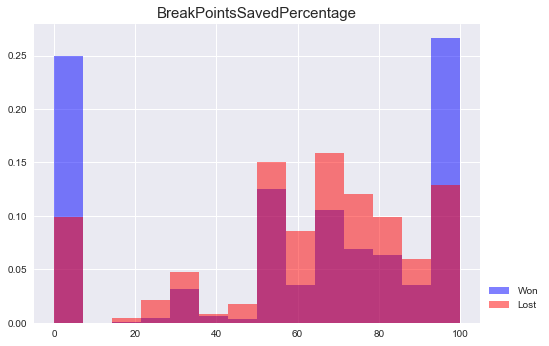

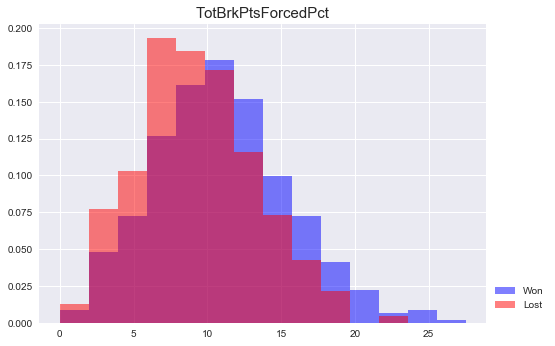

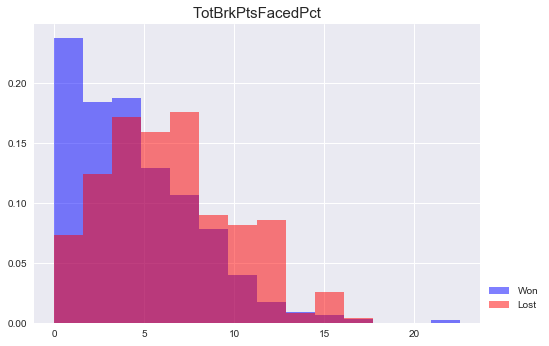

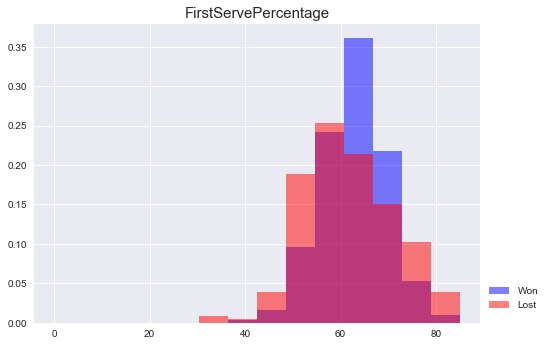

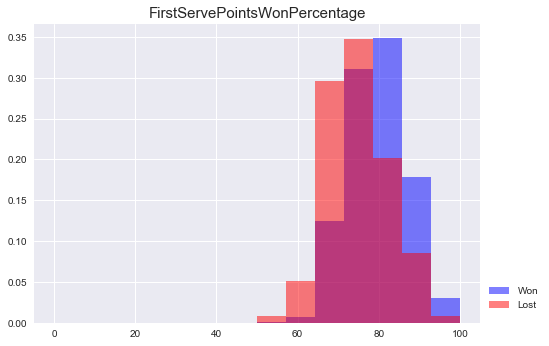

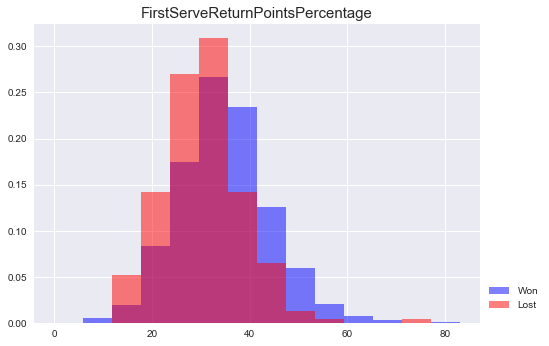

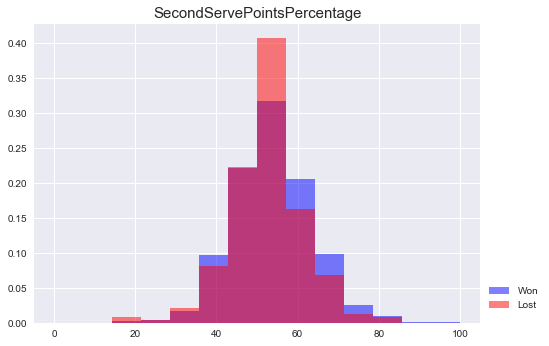

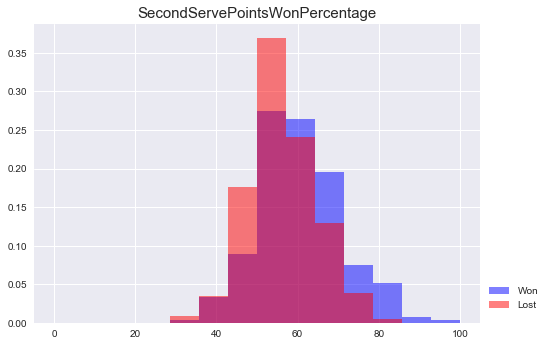

In [24]:
import matplotlib.pyplot as plt
import seaborn

for c in col:
    wins = df[c][df.Result==1]
    losses = df[c][df.Result==0]
    
    wins.hist(color='b', alpha=.5, weights=np.ones_like(wins)/len(wins), bins=np.linspace(0,df[c].max(),15), label="Won")
    losses.hist(color='r', alpha=.5, weights=np.ones_like(losses)/len(losses), bins=np.linspace(0,df[c].max(),15), label="Lost")
    plt.title(c, fontsize=15)
    plt.legend(bbox_to_anchor=(1.15,.15))
    plt.show()

While there is some separation in each feature, there isn't one that clearly stands out as a good predictor. Therefore, we will turn to a subset of the classification algorithms we have learned in class this year.

## Developing the Model

I will use the following functions to help me test my model as I refine it.

In [24]:
def test_model(model, features, target, iters=20):
    """
    Test a decision tree model based on inputed data and target.
    Print the average accuracy and average training time of the model.
    
    Inputs:
        model - sklearn classifier object. Must have a 'fit' method and 
                a binary 'predict' method.
        features - features of the data
        target - target values for the data
        iters (optional) - number of iterations to test model. 
            Defaults to 50.
    """
    acc = []
    t = []
    for i in xrange(iters):
        # create a new train-test split each iteration
        Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.7)
        
        # fit and time
        before = time.time()
        tree.fit(Xtrain, ytrain)
        after = time.time()
        t.append(after-before)
        
        # calculate and store accuracy
        print tree.predict(Xtest).mean()
        acc.append((tree.predict(Xtest) == ytest).mean())
    print "Average accuracy rate:", np.mean(acc)
    print "Average training time:", np.mean(t)
    
def report(results, n_top=3):
    """
    Reports the 'n_top' performers from grid search results.
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Baseline Models

In [14]:
lr = LogisticRegression()
test_model(lr, data, targets)

Average misclassification rate: 0.146194225722
Average training time: 0.0163799643517


In [15]:
rfc = RandomForestClassifier()
test_model(rfc, data, targets)

Average misclassification rate: 0.161679790026
Average training time: 0.0465650677681


In [17]:
svm = SVC(kernel='linear')
test_model(svm, data, targets, iters=5)

Average misclassification rate: 0.17532808399
Average training time: 4.72892465591


In [16]:
xgb = XGBClassifier()
test_model(xgb, data, targets)

Average misclassification rate: 0.145275590551
Average training time: 0.0888205647469


## Parameter Tuning
This section will take a while to execute, so it is probably in your best interest not to try to duplicate the results here.

### Tune Logistic Regression

In [38]:
param_grid = {
    'C':[.5,1,3,5,7], 
    'class_weight':[{0:1}, {0:1.25}, {0:1.5}, {0:1.75}, {0:2}]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.845 (std: 0.016)
Parameters: {'C': 5, 'class_weight': {0: 1}}

Model with rank: 1
Mean validation score: 0.845 (std: 0.016)
Parameters: {'C': 7, 'class_weight': {0: 1}}



### Tune SVM

In [45]:
param_grid = {
    'C':[.5,1,3,5,7], 
    'class_weight':[{0:1}, {0:1.25}, {0:1.5}, {0:1.75}, {0:2}]
}
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.844 (std: 0.015)
Parameters: {'C': 7, 'class_weight': {0: 1.25}}



### Tune Random Forest

In [48]:
param_grid = {
    'criterion':['entropy', 'gini'],
    'n_estimators':[10,30,50],
    'max_depth':[3,4,5,6,7],
    'min_samples_leaf':[1,2,3,4]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.858 (std: 0.019)
Parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}



### Tune XGBoost
Due to the large number of parameters in an XGBoost Classifier, I had to do the grid search in parts to make it the runtime reasonable.

In [51]:
params = {
    'n_estimators': [150, 175, 200], 
    'max_depth': [2,3,4]
}

grid_search = GridSearchCV(XGBClassifier(), params)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.853 (std: 0.024)
Parameters: {'n_estimators': 175, 'max_depth': 2}



In [52]:
params = {
    'n_estimators': [175], 
    'max_depth': [2],
    'learning_rate':[0.05,0.1,0.2],
    'gamma':[0.5, 0.7, 0.9, 1]
}

grid_search = GridSearchCV(XGBClassifier(), params)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.857 (std: 0.020)
Parameters: {'n_estimators': 175, 'learning_rate': 0.2, 'max_depth': 2, 'gamma': 0.7}



In [53]:
params = {
    'n_estimators': [175], 
    'max_depth': [2],
    'learning_rate':[0.2],
    'gamma':[0.7],
    'colsample_bytree':[0.5,0.7,1],
    'subsample':[0.5,0.7,1]
}

grid_search = GridSearchCV(XGBClassifier(), params)
grid_search.fit(data, targets)
report(grid_search.cv_results_, n_top=1)

Model with rank: 1
Mean validation score: 0.857 (std: 0.021)
Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'n_estimators': 175, 'subsample': 1, 'max_depth': 2, 'gamma': 0.7}

Model with rank: 1
Mean validation score: 0.857 (std: 0.020)
Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'n_estimators': 175, 'subsample': 1, 'max_depth': 2, 'gamma': 0.7}



## Final Models and Testing
Now I create my final models using all the information gained from the grid searches above. While I recognize I didn't perform an exhaustive grid search by any means, it is clear that there was some improvement.

In [54]:
lr_list = []
svm_list = []
rfc_list = []
xgb_list = []
tuned_xgb_list = []
ensembled_list = []

lr = LogisticRegression(C=5)
svm = SVC(kernel='linear', C=7, class_weight={0:1.25})
rfc = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=5, min_samples_leaf=3)
xgb = XGBClassifier(n_estimators=175, max_depth=2, gamma=.7, learning_rate=.2)

for i in xrange(50):
    Xtrain, Xtest, ytrain, ytest = train_test_split(data, targets, train_size=.7)
    
    lr.fit(Xtrain, ytrain)
    svm.fit(Xtrain, ytrain)
    rfc.fit(Xtrain, ytrain)
    xgb.fit(Xtrain, ytrain)
    tuned_xgb.fit(Xtrain, ytrain)
    
    lr_list.append((lr.predict(Xtest) == ytest).mean())
    svm_list.append((svm.predict(Xtest) == ytest).mean())
    rfc_list.append((rfc.predict(Xtest) == ytest).mean())
    xgb_list.append((xgb.predict(Xtest) == ytest).mean())
    tuned_xgb_list.append((tuned_xgb.predict(Xtest) == ytest).mean())
    
    ensembled_prediction = lr.predict(Xtest) + svm.predict(Xtest) + \
        rfc.predict(Xtest) + xgb.predict(Xtest) + tuned_xgb.predict(Xtest)
    ensembled_prediction = .2*ensembled_prediction.copy()
    
    ensembled_list.append(((ensembled_prediction > .5).astype(int) == ytest).mean())
    
print "Logistic Regression:\t", np.mean(lr_list)
print "SVM with Linear Kernel:\t", np.mean(svm_list)
print "Random Forest:\t\t", np.mean(rfc_list)
print "XGBoost Tree:\t\t", np.mean(xgb_list)
print "XGBoost Tree (Tuned):\t", np.mean(tuned_xgb_list)
print "Ensembled Model:\t", np.mean(ensembled_list)

Logistic Regression:	0.851916010499
SVM with Linear Kernel:	0.850078740157
Random Forest:		0.849081364829
XGBoost Tree:		0.858792650919
XGBoost Tree (Tuned):	0.855905511811
Ensembled Model:	0.862572178478


## Final Thoughts
This is the first time I have utilized the power of ensembling multiple models. I was very pleased to see 
that it performed better than any individual model. This suggests that the models were each learning distinct
features about the data.

Roger Federer has won about 81% of his matches, therefore, 86.25% accuracy isn't a great classifier, but it is 
a decent start. 
Because most of the features I used were percentages, this model can be used as a simple predictor during 
a match to predict the final result.

I hypothesize that other useful features would be:
- Forehand winners
- Backhand winners
- Net Points
- Forehand Unforced Errors
- Backhand Unforced Errors


These features are a better indicator of how each of the points ended. Therefore, it is a good metric for how 
the match is progressing at a lower level. Unfortunately, these features were not available on the website I scraped. In fact, I couldn't find detailed
statistics in these categories in any public dataset online.